# Travelling Salesman Problem with subtour elimination
[![tsp_simple_cuts_generic.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/amplcolab/blob/master/authors/mapgccv/callbacks/tsp_simple_cuts_generic.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/amplcolab/blob/master/authors/mapgccv/callbacks/tsp_simple_cuts_generic.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/amplcolab/blob/master/authors/mapgccv/callbacks/tsp_simple_cuts_generic.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/amplcolab/blob/master/authors/mapgccv/callbacks/tsp_simple_cuts_generic.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/amplcolab/blob/master/authors/mapgccv/callbacks/tsp_simple_cuts_generic.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/amplcolab/blob/master/authors/mapgccv/callbacks/tsp_simple_cuts_generic.ipynb)](https://colab.ampl.com)

Description: this example shows how to solve a TSP  by eliminating subtours using amplpy and ampls

Tags: callbacks, tsp

Notebook author: Christian Valente <<christian.valente@gmail.com>>

Model author: N/A

In [1]:
import os
if not os.path.isdir('tsp_inputs'):
    os.system('git clone https://github.com/ampl/amplcolab.git')
    os.chdir('amplcolab/authors/mapgccv/callbacks')

### Setup and cloud integration

In [1]:
# Install dependencies
!pip install -q amplpy amplpy-gurobi amplpy-cplex
!pip install -q tsplib95 matplotlib

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["coin"], # modules to install
    license_uuid="default", # license to use
    g=globals()) # instantiate AMPL object and register magics

### Options

In [3]:
import os
#if os.path.isdir('ampls-api'):
#    os.chdir('ampls-api/python/examples/notebooks/')
USE_CALLBACKS = True
PLOTSUBTOURS = True
TSP_FILE = "./tsp_inputs/a280.tsp"

### Imports

In [ ]:
SOLVER = "gurobi"
SOLVER_OPTIONS = ['outlev=1']
# Import utilities
from amplpy import AMPL, DataFrame  # pip install amplpy
if SOLVER == "gurobi":
    import amplpy_gurobi as ampls   # pip install amplpy-gurobi
elif SOLVER == "cplex":
    import amplpy_cplex as ampls    # pip install amplpy-cplex
elif SOLVER == "xpress":
    import amplpy_xpress as ampls   # pip install amplpy-gurobi
import tsplib95 as tsp              # pip install tsplib95
import matplotlib.pyplot as plt     # pip install matplotlib
import matplotlib.colors as colors
from time import time
plt.rcParams['figure.dpi'] = 200

### Define TSP model in AMPL

We are using amplpy to define the subtour elimination constraint in AMPL and instantiating it appropriately and ampls to add cuts directly from the solver callback.

In [5]:
%%ampl
set NODES ordered;
param hpos {NODES};
param vpos {NODES};

set PAIRS := {i in NODES, j in NODES: ord(i) < ord(j)};

param distance {(i,j) in PAIRS}
   := sqrt((hpos[j]-hpos[i])**2 + (vpos[j]-vpos[i])**2);

var X {PAIRS} binary;

minimize Tour_Length: sum {(i,j) in PAIRS} distance[i,j] * X[i,j];

subject to Visit_All {i in NODES}:
   sum {(i, j) in PAIRS} X[i,j] + sum {(j, i) in PAIRS} X[j,i] = 2;

Function to load TSP data files and return a dictionary of (nodeid : coordinate)

In [6]:
def getDictFromTspFile(tspFile):
    p = tsp.load(tspFile)
    if not p.is_depictable:
        print("Problem is not depictable!")

    # Amendments as we need the nodes lexographically ordered
    nnodes = len(list(p.get_nodes()))
    i = 0
    while nnodes>1:
        nnodes = nnodes/10
        i+=1
    formatString = f"{{:0{i}d}}"
    nodes = {formatString.format(value) : p.node_coords[index+1] for index, value in enumerate(p.get_nodes())}
    return nodes

Create AMPL object with amplpy and load model and data

In [7]:
# Get the model from the cell above
tsp_model = _ampl_cells[0]

# Load model in AMPL
ampl = AMPL()
ampl.eval(tsp_model)
ampl.option["solver"] = SOLVER
ampl.option[SOLVER + "_options"] = ' '.join(SOLVER_OPTIONS)

# Set problem data from tsp file
nodes = getDictFromTspFile(TSP_FILE)

# Pass them to AMPL using a dataframe
df = DataFrame(index=[('NODES')], columns=['hpos', 'vpos'])
df.setValues(nodes)
ampl.setData(df, "NODES")

# Set some globals that never change during the execution of the problem
NODES = set(nodes.keys())
CPOINTS = {node : complex(coordinate[0], coordinate[1]) for (node, coordinate) in nodes.items()}

Define some helpers functions to plot the tours

In [8]:
def plotTours(tours: list, points_coordinate: dict):
    # Plot all the tours in the list each with a different color
    colors = ['b', 'g', 'c', 'm', 'y', 'k']
    for i, tour in enumerate(tours):
        tourCoordinates = [points_coordinate[point.strip("'")] for point in tour]
        color = colors[i % len(colors)]
        plot_all(tourCoordinates, color = color)
    plt.show()

def plot_all(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], 's', alpha=alpha, color=color)
    
def plotline(points, style='o-', alpha=1, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    if color:
        plt.plot(X, Y, style, alpha=alpha, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

Define some helper functions to help with the graphs (e.g. get the subtour given a set of arcs)

In [9]:
# Graphs helper routines
def trasverse(node, arcs: set, allnodes: set, subtour = None) -> list:
    # Trasverses all the arcs in the set arcs, starting from node
    # and returns the tour
    if not subtour:
        subtour = list()
    # Find arcs involving the current node
    myarcs = [(i,j) for (i,j) in arcs if node == i or node == j]
    if len(myarcs) == 0:
        return 
    # Append the current node to the current subtour
    subtour.append(node)

    # Use the first arc found
    myarc = myarcs[0]
    # Find destination (or origin) node
    destination = next(i for i in myarc if i != node)
    # Remove from arcs and nodes to visit
    arcs.remove(myarc)
    if node in allnodes:
        allnodes.remove(node)

    trasverse(destination, arcs, allnodes, subtour)
    return subtour


def findSubTours(arcs: set, allnodes: set):
    """Find all the subtours defined by a set of arcs and
       return them as a list of list
    """
    subtours = list()
    allnodes = allnodes.copy()
    while len(allnodes) > 0:
        l = trasverse(next(iter(allnodes)), arcs, allnodes)
        subtours.append(l)
    return subtours

AMPLPY implementation of sub-tours elimination

In [10]:
def amplSubTourElimination(ampl: AMPL):
    # Add the constraint and the needed parameters
    subToursAMPL = """param nSubtours >= 0 integer, default 0;
    set SUB {1..nSubtours} within NODES;

    subject to Subtour_Elimination {k in 1..nSubtours}:
    sum {i in SUB[k], j in NODES diff SUB[k]} 
    if (i, j) in PAIRS then X[i, j] else X[j, i] >= 2;"""
    ampl.eval(subToursAMPL)

    nSubtoursParam = ampl.getParameter("nSubtours")
    SubtoursSet = ampl.getSet("SUB")

    allsubtours = list()
    while True: # Repeat until the solution contains only one tour
        ampl.solve()
        # Get solution
        ARCS = ampl.getData("{(i,j) in PAIRS : X[i,j] > 0} X[i,j];")
        ARCS = set([(i, j) for (i, j, k)in ARCS.toList()])
        subtours = findSubTours(ARCS, NODES)
        # If we have only one tour, the solution is valid
        if len(subtours) <= 1:
            break
        print(f"Found {len(subtours)} subtours, plotting them and adding cuts")
        if PLOTSUBTOURS:
            plotTours(subtours, CPOINTS)
        # Else add the current tours to the list of subtours
        allsubtours.extend(subtours)
        # And add those to the constraints by assigning the values to
        # the parameter and the set
        nSubtoursParam.set(len(allsubtours))
        for (i, tour) in enumerate(allsubtours):
            SubtoursSet[i+1].setValues(tour)

ampls callbacks implementation of subtours elimination

In [11]:
# Callback class that actually add the cuts if subtours are found in a solution
class MyCallback(ampls.GenericCallback):
    def __init__(self): 
        # Constructor, simply sets the iteration number to 0
        super().__init__()
        self.iteration = 0 
    def run(self):
        try:
            # For each solution
            if self.getAMPLWhere() == ampls.Where.MIPSOL:
                self.iteration += 1
                print(f"\nIteration {self.iteration}: Finding subtours")
                sol = self.getSolutionVector()
                arcs = [xvars[i] for i, value in enumerate(sol) if value > 0]
                subTours = findSubTours(set(arcs), set(vertices))
                if len(subTours) ==1:
                    print("No subtours detected. Not adding any cut")
                    return 0
                print(f"Adding {len(subTours)} cuts")
                if PLOTSUBTOURS:
                    plotTours(subTours, CPOINTS)
                for subTour in subTours:
                    st1 = set(subTour)
                    nst1 = set(vertices) - st1
                    externalArcs = [(i, j) if i < j else (j, i) for i in st1 for j in nst1]
                    varsExternalArcs = [xinverse[i, j] for (i, j) in externalArcs]
                    coeffs = [1 for i in range(len(varsExternalArcs))]
                    if PLOTSUBTOURS:
                        print("Adding cut for subtour:", st1)
                    self.addLazyIndices(varsExternalArcs, coeffs, ampls.CutDirection.GE, 2)
                    if len(subTours) == 2:
                        return 0
                print("Continue solving")
            return 0
        except Exception as e:
            print('Error:', e)
            return 1

In [12]:
# Global variables to store entities needed by the callbacks
# that never change
xvars = None
xinverse = None
vertices = None
def solverSubTourElimination(ampl: AMPL, solver, solver_options):
    global xvars, xinverse, vertices
    # Export the model using ampls
    model = ampl.exportModel(solver, solver_options)
    model.enableLazyConstraints()

    # Get the global maps between solver vars and AMPL entities
    varMap = model.getVarMapFiltered("X")
    #print("varMap:", varMap)
    inverse = model.getVarMapInverse()
    xvars = {index: ampls.var2tuple(var)[1:] for var, index in varMap.items()}
    xinverse = {ampls.var2tuple(var)[1:]: index for index, var in inverse.items()}
    vertices = list(sorted(set([x[0] for x in xvars.values()] + [x[1] for x in xvars.values()])))

    # Assign the callback
    callback = MyCallback()
    model.setCallback(callback)
    print("Start optimization")
    # Start the optimization
    model.optimize()
    # Import the solution back to AMPL
    ampl.importSolution(model)

Script running the optimization

Start optimization

Iteration 1: Finding subtours
Adding 5 cuts


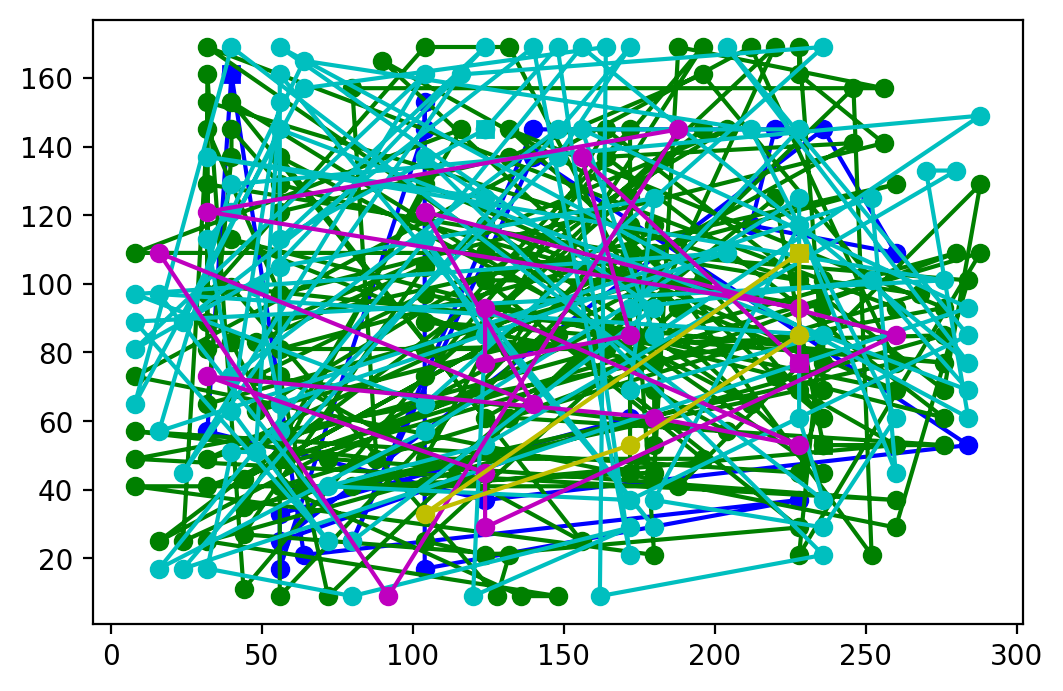

Adding cut for subtour: {'049', '248', '130', '274', '235', '103', '171', '217', '102', '184', '276', '082', '101', '262', '021', '165', '169', '030', '146', '125'}
Adding cut for subtour: {'189', '210', '214', '014', '120', '178', '052', '083', '229', '107', '272', '243', '108', '064', '199', '265', '041', '018', '092', '032', '141', '195', '279', '093', '075', '008', '164', '080', '118', '149', '224', '269', '220', '114', '051', '126', '215', '078', '161', '115', '081', '193', '268', '059', '157', '209', '186', '191', '176', '242', '250', '033', '105', '094', '042', '011', '004', '128', '015', '267', '246', '223', '047', '099', '232', '010', '221', '203', '117', '158', '077', '230', '264', '100', '150', '162', '202', '234', '048', '065', '053', '034', '090', '104', '086', '233', '190', '225', '137', '027', '168', '231', '241', '247', '005', '054', '129', '156', '207', '142', '256', '112', '277', '187', '204', '073', '043', '002', '181', '245', '200', '261', '063', '153', '116', '255'

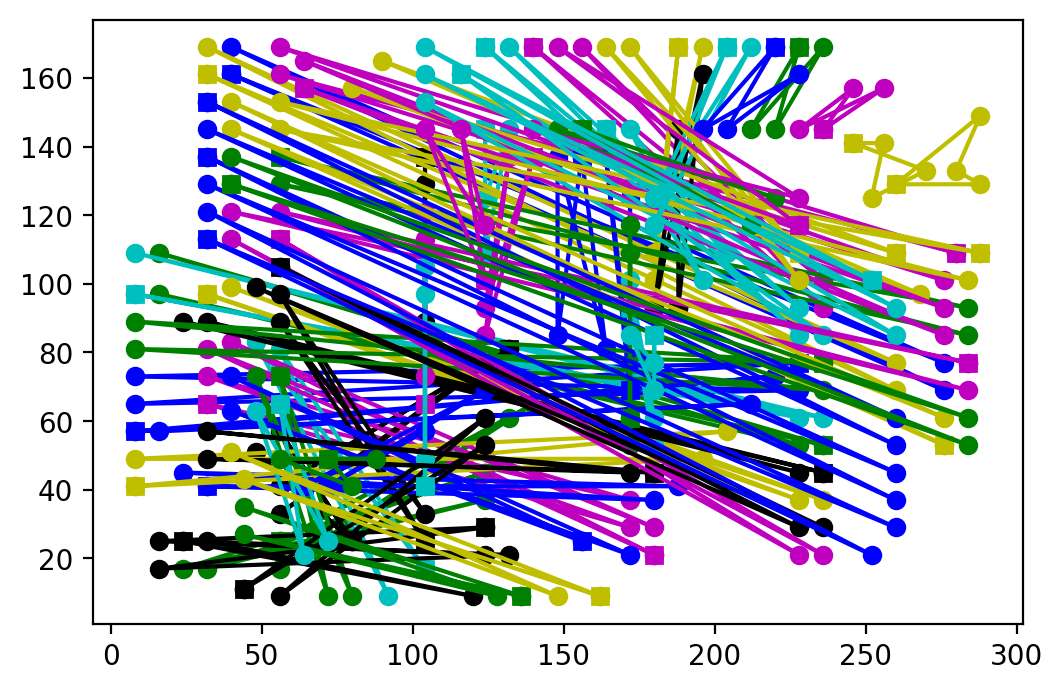

Adding cut for subtour: {'049', '050', '231', '232'}
Adding cut for subtour: {'067', '068', '214', '213'}
Adding cut for subtour: {'128', '153', '154', '127'}
Adding cut for subtour: {'026', '255', '025', '256'}
Adding cut for subtour: {'013', '014', '267', '268'}
Adding cut for subtour: {'124', '123', '157', '158'}
Adding cut for subtour: {'074', '207', '208', '073'}
Adding cut for subtour: {'184', '098', '183', '097'}
Adding cut for subtour: {'070', '211', '212', '069'}
Adding cut for subtour: {'084', '083', '198', '197'}
Adding cut for subtour: {'051', '229', '230', '052'}
Adding cut for subtour: {'104', '103', '178', '177'}
Adding cut for subtour: {'148', '134', '133', '147'}
Adding cut for subtour: {'180', '101', '102', '179'}
Adding cut for subtour: {'116', '166', '165', '115'}
Adding cut for subtour: {'037', '244', '038', '243'}
Adding cut for subtour: {'063', '218', '217', '064'}
Adding cut for subtour: {'266', '016', '265', '015'}
Adding cut for subtour: {'150', '149', '132', 

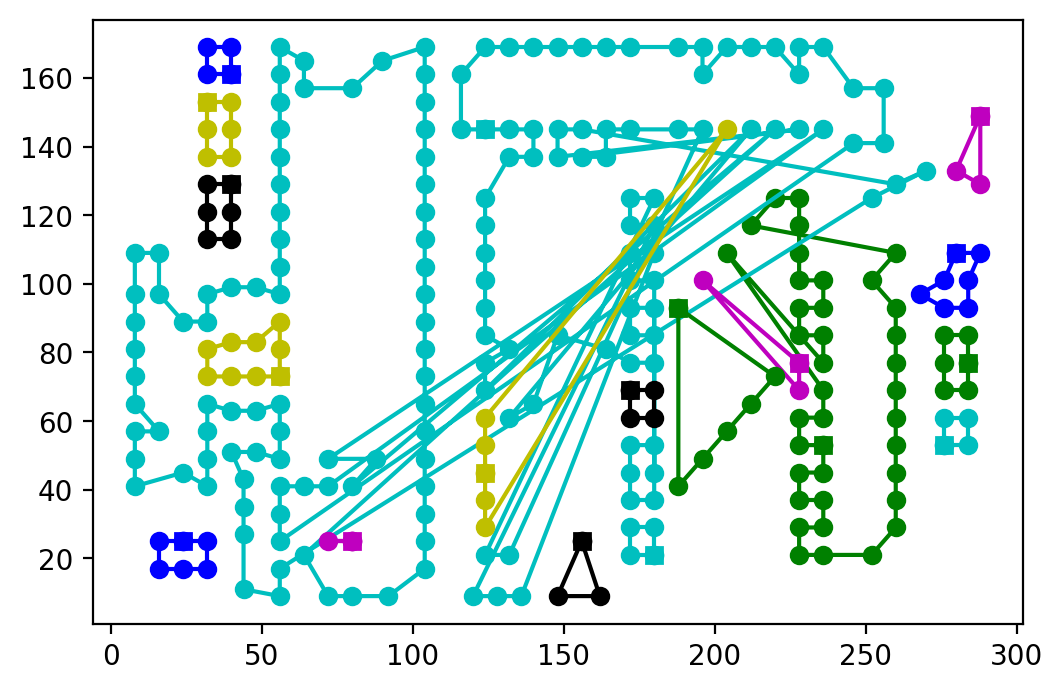

Adding cut for subtour: {'049', '051', '050', '052'}
Adding cut for subtour: {'248', '210', '230', '214', '255', '224', '228', '222', '227', '220', '259', '226', '249', '216', '215', '229', '213', '212', '218', '209', '225', '253', '250', '260', '211', '256', '254', '252', '223', '258', '217', '257', '219', '251', '262', '261', '221', '263'}
Adding cut for subtour: {'189', '127', '026', '014', '061', '124', '120', '070', '083', '178', '102', '107', '062', '165', '031', '108', '020', '064', '154', '199', '132', '041', '018', '140', '092', '032', '037', '068', '141', '188', '279', '075', '008', '028', '130', '164', '080', '118', '007', '149', '278', '269', '138', '270', '126', '035', '078', '161', '072', '081', '109', '157', '268', '029', '016', '160', '067', '186', '176', '122', '033', '105', '089', '042', '011', '004', '128', '030', '074', '088', '012', '015', '267', '071', '103', '099', '010', '101', '019', '158', '077', '023', '179', '169', '276', '162', '100', '150', '024', '106', '

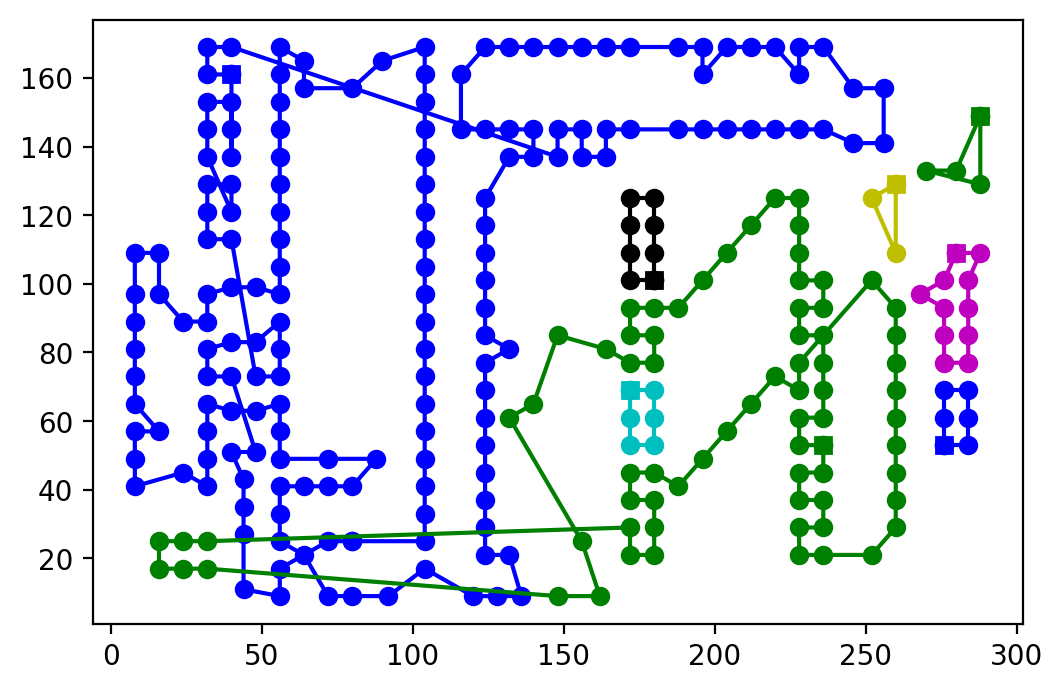

Adding cut for subtour: {'189', '049', '127', '026', '014', '061', '124', '058', '120', '183', '070', '083', '178', '052', '171', '102', '107', '062', '272', '165', '031', '108', '020', '064', '154', '132', '041', '018', '092', '032', '037', '068', '188', '172', '075', '008', '130', '028', '164', '080', '118', '007', '114', '126', '035', '051', '078', '161', '115', '072', '081', '109', '157', '059', '186', '029', '160', '067', '176', '016', '122', '033', '089', '105', '044', '042', '182', '011', '004', '128', '030', '074', '088', '015', '012', '071', '047', '103', '099', '010', '101', '184', '117', '019', '158', '077', '023', '169', '100', '162', '276', '048', '185', '024', '106', '065', '053', '034', '090', '104', '086', '167', '166', '087', '190', '027', '111', '168', '005', '054', '129', '156', '177', '079', '084', '112', '050', '277', '187', '073', '043', '181', '036', '055', '163', '021', '063', '153', '175', '110', '116', '045', '013', '040', '121', '076', '006', '039', '038', '1

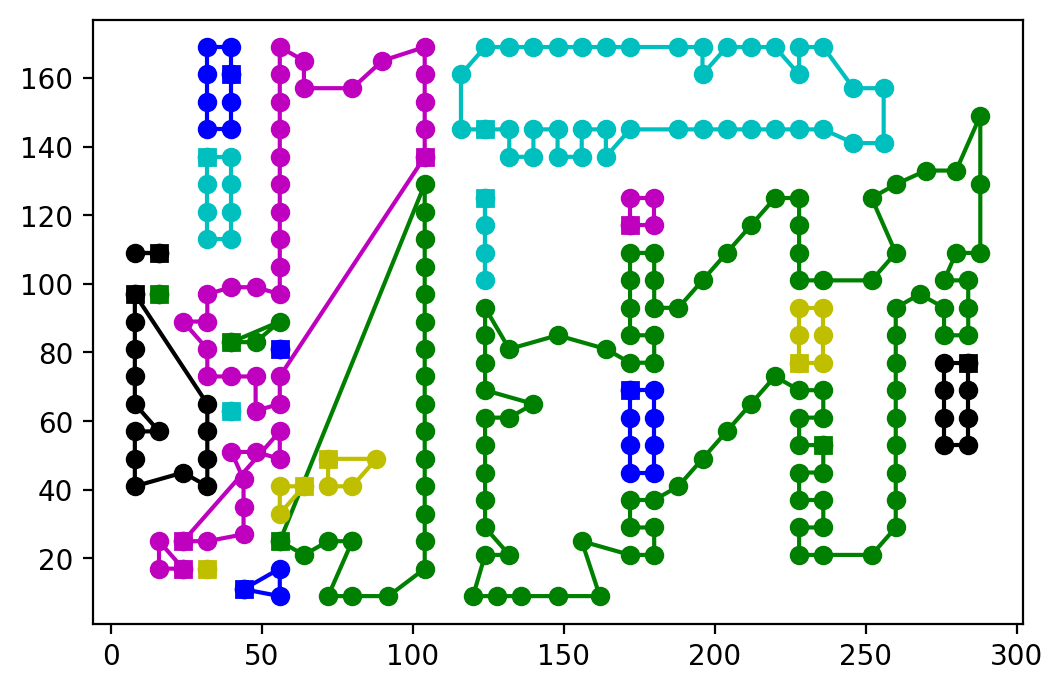

Adding cut for subtour: {'048', '049', '051', '047', '053', '050', '054', '052'}
Adding cut for subtour: {'189', '210', '214', '183', '240', '178', '194', '229', '213', '243', '265', '140', '141', '195', '188', '279', '217', '248', '196', '149', '224', '222', '244', '278', '220', '138', '215', '239', '218', '193', '268', '191', '186', '176', '242', '250', '182', '267', '246', '223', '258', '251', '221', '184', '203', '230', '179', '264', '259', '150', '202', '001', '185', '198', '212', '266', '280', '190', '139', '225', '247', '241', '137', '260', '207', '177', '256', '187', '204', '002', '181', '245', '262', '261', '263', '197', '201', '228', '180', '227', '136', '226', '003', '249', '216', '205', '192', '211', '151', '152', '257', '219', '148', '206'}
Adding cut for subtour: {'028', '130', '023', '127', '026', '014', '007', '276', '013', '006', '126', '024', '272', '273', '020', '029', '016', '027', '022', '005', '017', '131', '129', '025', '011', '004', '132', '128', '018', '012', '

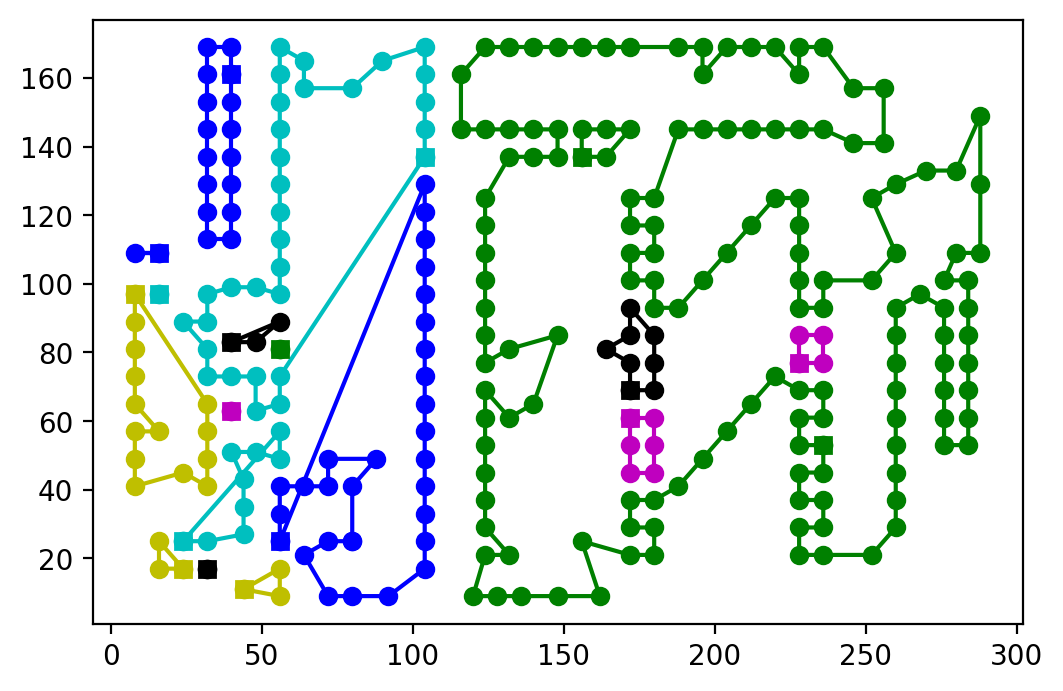

Adding cut for subtour: {'048', '049', '046', '051', '047', '053', '055', '057', '054', '050', '044', '045', '058', '056', '052', '059'}
Adding cut for subtour: {'189', '210', '214', '127', '026', '014', '183', '240', '178', '194', '229', '213', '272', '243', '020', '154', '265', '254', '195', '188', '279', '217', '008', '248', '028', '130', '196', '007', '224', '222', '244', '278', '269', '220', '270', '126', '237', '215', '239', '218', '193', '268', '191', '029', '016', '186', '176', '235', '242', '250', '182', '011', '004', '128', '267', '246', '012', '238', '223', '015', '258', '232', '251', '010', '221', '184', '203', '230', '023', '179', '264', '276', '259', '150', '202', '234', '001', '185', '024', '198', '212', '266', '233', '280', '190', '225', '247', '231', '241', '137', '027', '005', '260', '129', '156', '207', '177', '256', '277', '187', '204', '002', '181', '245', '262', '261', '021', '263', '153', '197', '255', '201', '228', '180', '227', '013', '136', '006', '226', '003'

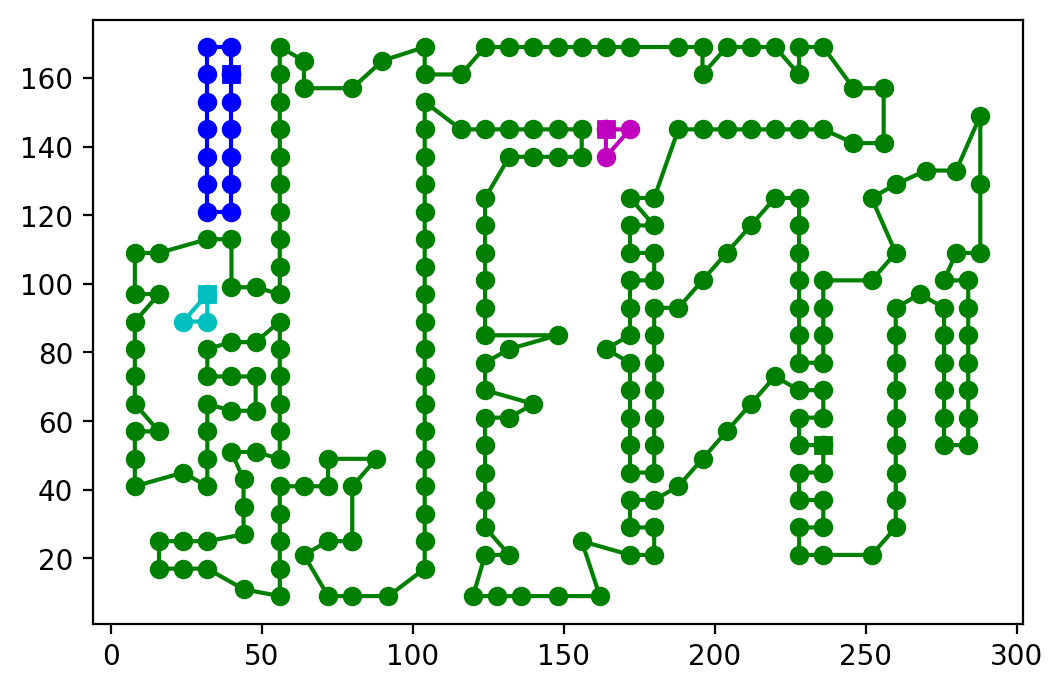

Adding cut for subtour: {'048', '049', '046', '051', '047', '053', '055', '057', '054', '050', '044', '045', '056', '052'}
Adding cut for subtour: {'189', '210', '214', '127', '026', '014', '061', '124', '208', '058', '120', '183', '070', '240', '083', '178', '147', '194', '171', '229', '102', '213', '107', '062', '272', '243', '165', '031', '108', '020', '154', '199', '265', '132', '254', '041', '140', '143', '032', '092', '037', '068', '141', '195', '188', '279', '217', '093', '172', '075', '008', '248', '028', '130', '164', '080', '196', '149', '007', '118', '224', '222', '244', '278', '269', '220', '114', '138', '270', '126', '035', '237', '215', '078', '161', '239', '115', '072', '081', '109', '218', '193', '268', '059', '157', '209', '029', '016', '160', '067', '176', '186', '191', '235', '242', '122', '250', '033', '089', '094', '105', '042', '182', '011', '004', '128', '252', '074', '088', '146', '030', '267', '246', '012', '238', '223', '015', '071', '258', '103', '099', '232'

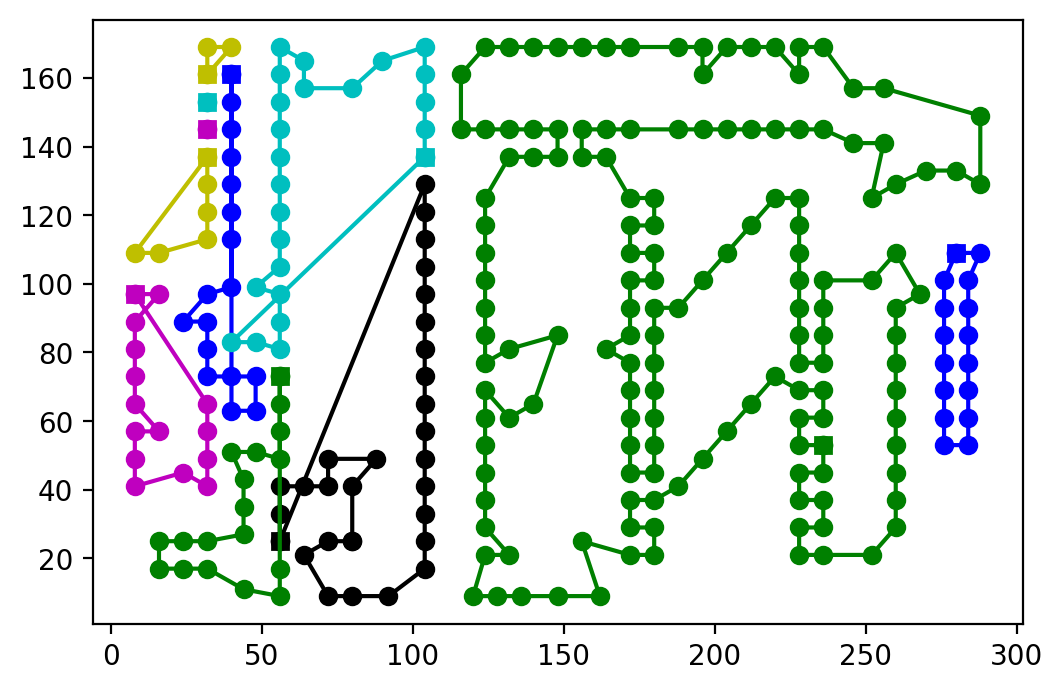

Adding cut for subtour: {'048', '049', '046', '064', '066', '065', '047', '044', '045', '112', '088', '113', '084', '085', '063', '087', '059'}
Adding cut for subtour: {'189', '210', '214', '127', '026', '014', '208', '183', '178', '147', '194', '229', '213', '272', '020', '154', '199', '265', '132', '254', '018', '140', '143', '141', '195', '188', '279', '217', '008', '248', '028', '130', '196', '149', '007', '224', '222', '278', '269', '220', '138', '270', '126', '215', '218', '193', '268', '209', '029', '016', '186', '176', '191', '250', '182', '011', '004', '128', '252', '146', '267', '012', '015', '223', '258', '251', '010', '221', '184', '203', '019', '230', '023', '179', '264', '276', '259', '150', '202', '001', '185', '024', '198', '212', '266', '280', '190', '139', '225', '247', '137', '027', '005', '260', '129', '156', '207', '142', '256', '177', '277', '187', '204', '002', '181', '200', '262', '261', '021', '263', '153', '197', '255', '201', '228', '180', '227', '013', '136'

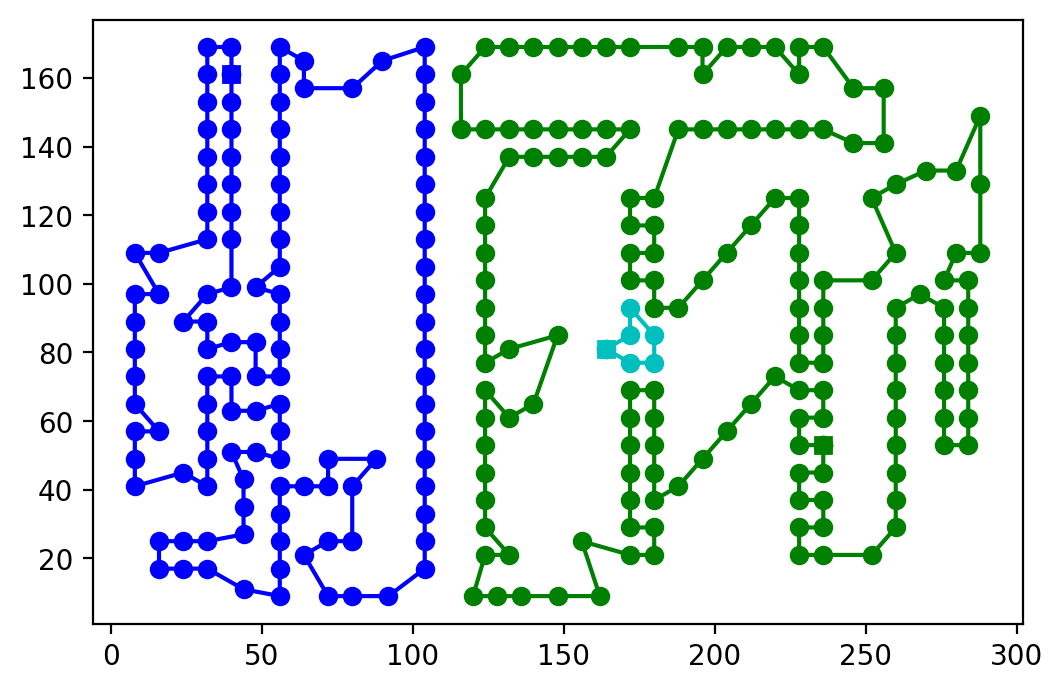

Adding cut for subtour: {'049', '061', '124', '058', '120', '070', '083', '052', '171', '102', '107', '062', '165', '031', '108', '064', '041', '092', '032', '037', '068', '093', '172', '075', '164', '080', '118', '114', '051', '035', '078', '161', '115', '072', '081', '109', '157', '059', '160', '067', '122', '033', '105', '094', '044', '042', '089', '030', '088', '074', '071', '047', '103', '099', '101', '117', '158', '077', '169', '100', '162', '048', '106', '097', '065', '053', '034', '090', '104', '086', '167', '166', '098', '096', '087', '168', '111', '054', '079', '112', '084', '050', '073', '043', '036', '055', '163', '063', '175', '110', '116', '045', '040', '121', '076', '039', '038', '174', '119', '082', '056', '113', '060', '069', '046', '173', '123', '085', '159', '066', '057', '170', '091', '095', '125'}
Adding cut for subtour: {'189', '210', '214', '127', '026', '014', '208', '183', '240', '178', '147', '194', '229', '213', '272', '243', '020', '154', '199', '265', '132'

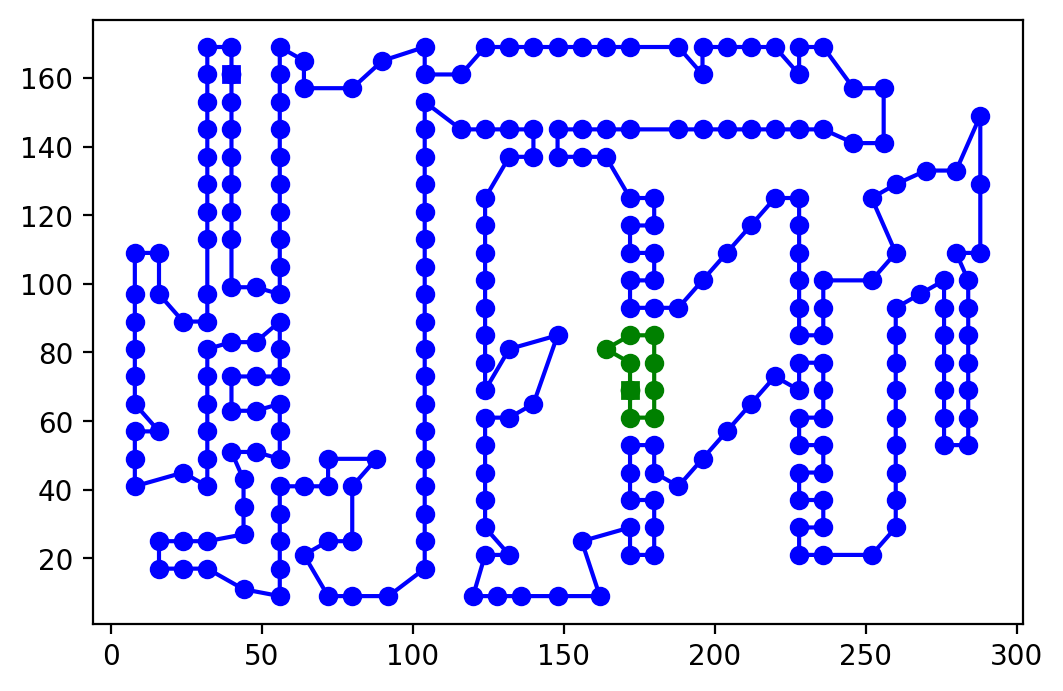

Adding cut for subtour: {'189', '049', '210', '214', '127', '026', '014', '061', '124', '208', '183', '120', '058', '070', '240', '178', '083', '052', '194', '171', '229', '213', '102', '107', '062', '272', '243', '165', '031', '020', '108', '064', '154', '199', '265', '132', '254', '041', '018', '092', '032', '037', '068', '195', '188', '279', '217', '093', '172', '075', '008', '028', '248', '130', '164', '196', '080', '118', '007', '224', '222', '244', '278', '269', '220', '114', '138', '270', '126', '035', '051', '237', '215', '078', '161', '239', '115', '072', '081', '109', '218', '193', '268', '059', '157', '209', '029', '016', '191', '186', '176', '160', '089', '235', '242', '122', '067', '033', '250', '105', '094', '044', '042', '182', '011', '004', '128', '252', '030', '088', '074', '015', '012', '267', '238', '246', '223', '071', '258', '047', '103', '099', '232', '010', '251', '101', '221', '184', '203', '117', '019', '158', '077', '023', '230', '179', '264', '169', '276', '2

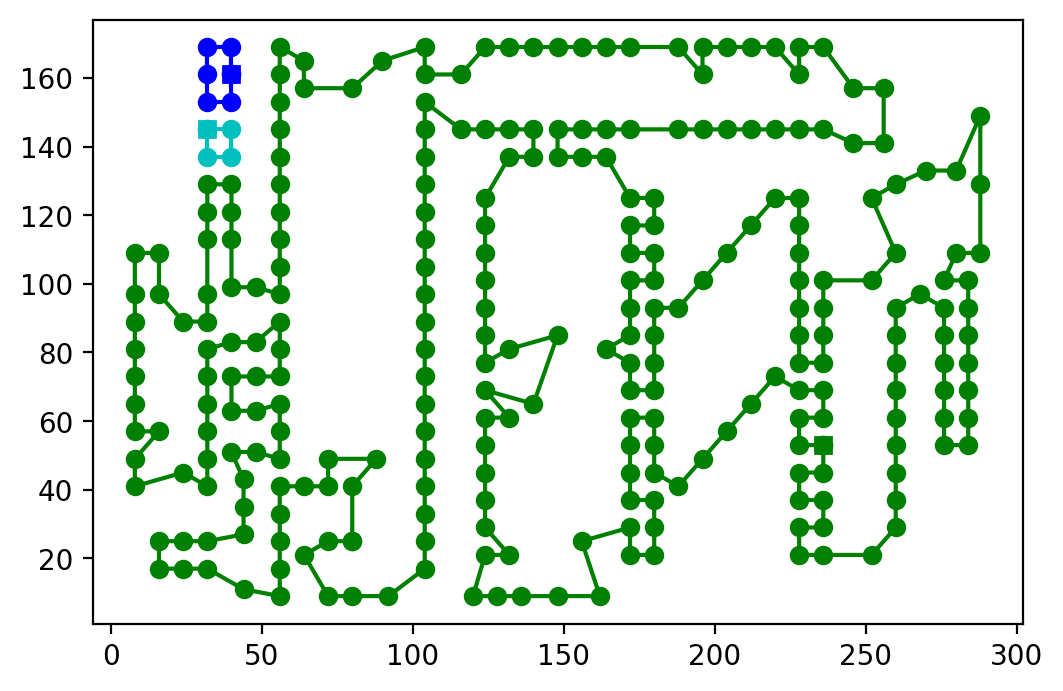

Adding cut for subtour: {'048', '049', '051', '053', '050', '052'}
Adding cut for subtour: {'189', '210', '214', '127', '026', '014', '061', '124', '208', '058', '120', '183', '070', '240', '083', '178', '147', '194', '171', '229', '102', '213', '107', '062', '272', '243', '165', '031', '020', '108', '064', '154', '199', '265', '132', '254', '041', '018', '140', '092', '032', '143', '037', '068', '141', '195', '188', '279', '217', '093', '172', '075', '008', '248', '028', '130', '164', '080', '196', '149', '007', '118', '224', '222', '244', '278', '269', '220', '114', '138', '270', '126', '035', '237', '215', '078', '161', '239', '115', '072', '081', '109', '218', '193', '268', '059', '157', '209', '029', '016', '160', '067', '176', '186', '191', '235', '242', '122', '250', '033', '089', '094', '044', '042', '105', '011', '004', '128', '252', '074', '088', '030', '182', '267', '246', '012', '238', '223', '015', '071', '146', '258', '103', '099', '232', '251', '010', '101', '221', '184'

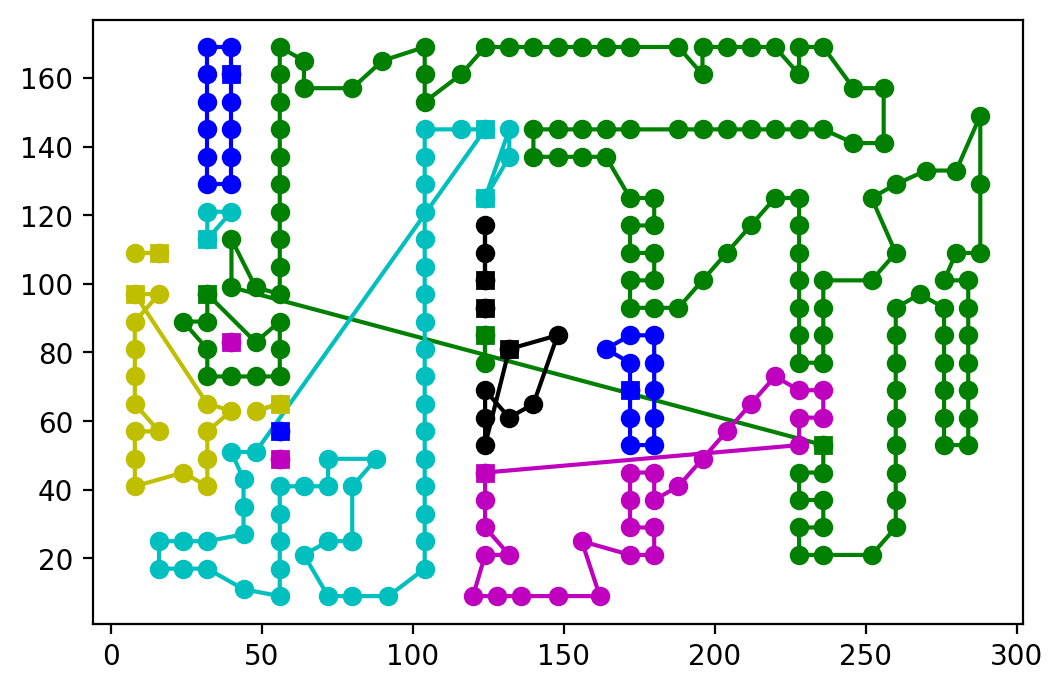

Adding cut for subtour: {'048', '049', '046', '051', '047', '053', '055', '054', '050', '045', '056', '052'}
Adding cut for subtour: {'214', '026', '014', '061', '208', '240', '229', '062', '272', '243', '031', '020', '265', '132', '254', '041', '018', '032', '037', '279', '217', '008', '248', '130', '028', '118', '007', '224', '222', '244', '278', '269', '220', '138', '270', '035', '237', '215', '239', '218', '268', '059', '209', '029', '016', '235', '242', '250', '033', '042', '011', '004', '252', '030', '267', '246', '012', '238', '223', '015', '258', '232', '251', '010', '221', '019', '230', '023', '264', '276', '259', '234', '001', '024', '034', '266', '233', '280', '225', '247', '231', '241', '137', '027', '005', '260', '256', '277', '043', '002', '245', '036', '262', '261', '021', '263', '063', '255', '228', '227', '013', '040', '136', '006', '226', '003', '249', '216', '039', '038', '060', '273', '236', '253', '131', '017', '022', '134', '025', '271', '133', '274', '135', '257'

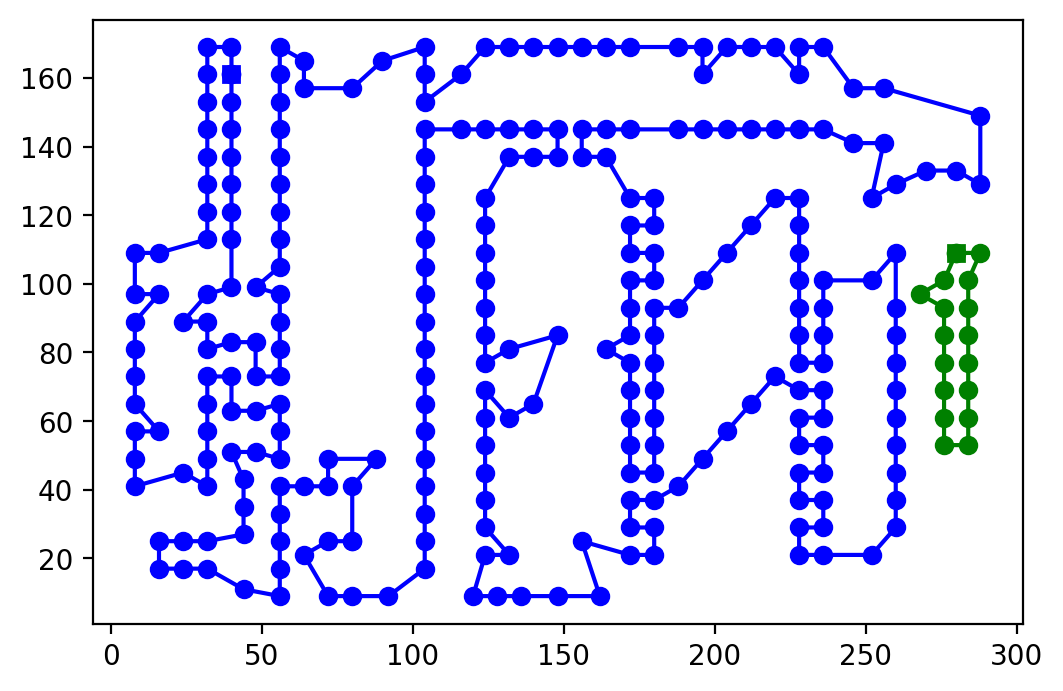

Adding cut for subtour: {'189', '049', '210', '214', '127', '026', '014', '061', '124', '208', '183', '120', '058', '070', '178', '083', '052', '147', '194', '171', '229', '213', '102', '107', '062', '272', '165', '031', '020', '108', '064', '154', '199', '265', '132', '254', '041', '018', '140', '143', '032', '092', '037', '068', '141', '195', '188', '279', '217', '093', '172', '075', '008', '028', '248', '130', '164', '196', '080', '118', '007', '149', '224', '222', '278', '269', '220', '114', '138', '270', '126', '035', '051', '215', '078', '161', '115', '072', '081', '109', '218', '193', '268', '059', '157', '209', '029', '016', '191', '186', '176', '160', '089', '067', '122', '033', '250', '105', '094', '044', '042', '182', '011', '004', '128', '030', '252', '088', '146', '074', '015', '012', '267', '223', '071', '258', '047', '103', '099', '010', '251', '101', '221', '184', '203', '117', '019', '158', '077', '023', '230', '179', '264', '169', '276', '259', '150', '162', '202', '1

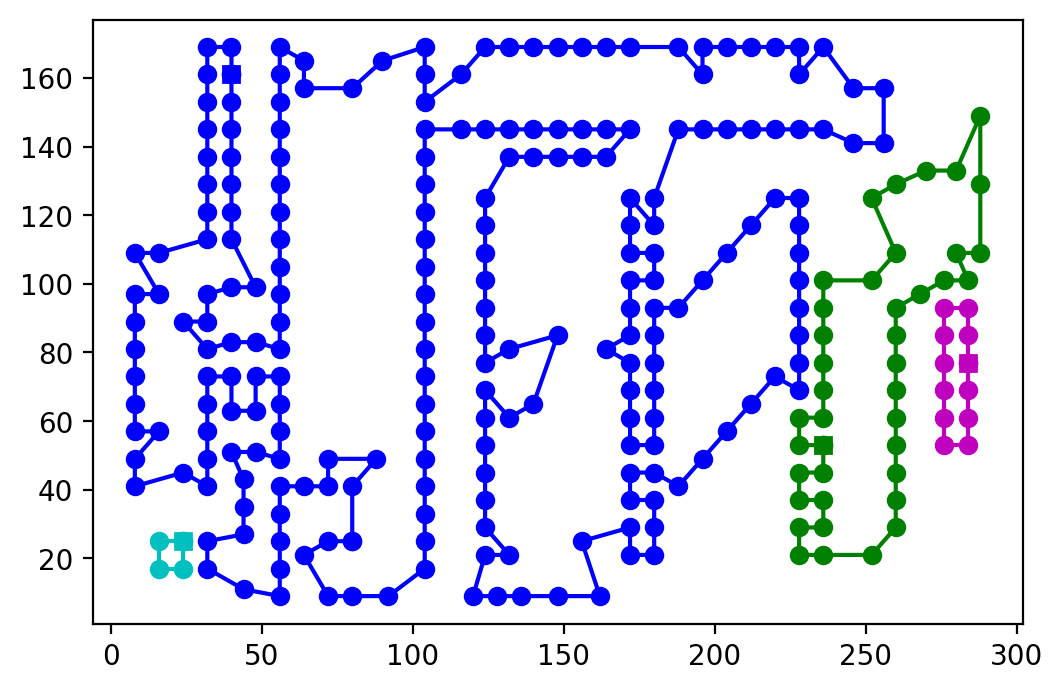

Adding cut for subtour: {'189', '049', '127', '026', '014', '061', '124', '208', '183', '120', '058', '070', '178', '083', '052', '147', '194', '171', '102', '107', '062', '272', '165', '031', '020', '108', '064', '154', '199', '265', '132', '254', '041', '018', '140', '143', '032', '092', '037', '068', '141', '195', '188', '093', '172', '075', '008', '028', '130', '164', '196', '080', '118', '007', '149', '269', '114', '138', '270', '126', '035', '051', '078', '161', '115', '072', '081', '109', '193', '268', '059', '157', '191', '029', '016', '186', '176', '160', '067', '122', '033', '105', '089', '044', '042', '182', '011', '004', '128', '030', '088', '074', '146', '015', '012', '267', '071', '258', '047', '103', '099', '010', '101', '184', '203', '117', '019', '158', '077', '023', '179', '264', '169', '276', '259', '150', '162', '202', '100', '048', '185', '024', '106', '198', '065', '053', '034', '090', '104', '086', '266', '166', '167', '098', '087', '190', '139', '137', '027', '1

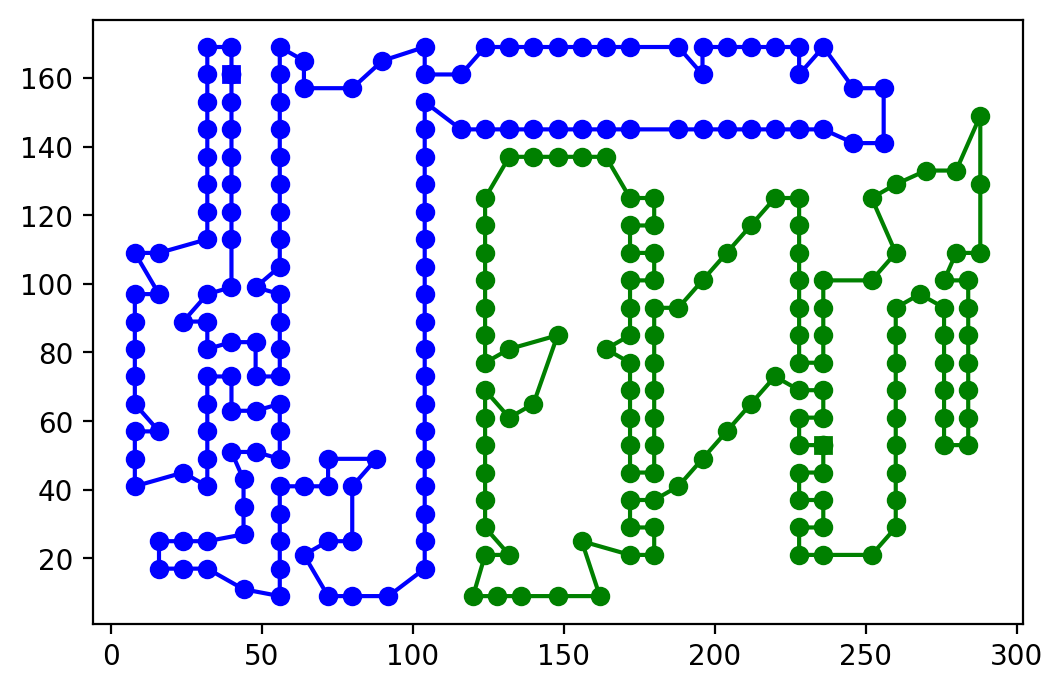

Adding cut for subtour: {'049', '127', '026', '014', '061', '124', '058', '120', '070', '083', '052', '171', '102', '107', '062', '272', '165', '031', '020', '108', '064', '041', '018', '092', '032', '037', '068', '093', '172', '075', '008', '028', '164', '080', '118', '007', '114', '126', '035', '051', '078', '161', '115', '072', '081', '109', '157', '059', '029', '016', '160', '067', '122', '033', '105', '094', '044', '042', '089', '011', '004', '128', '030', '088', '074', '015', '012', '071', '047', '103', '099', '010', '101', '117', '019', '158', '077', '023', '169', '276', '162', '100', '048', '024', '106', '097', '065', '053', '034', '090', '104', '086', '167', '166', '098', '096', '087', '027', '168', '111', '005', '054', '079', '112', '084', '050', '277', '073', '043', '036', '055', '163', '021', '063', '175', '110', '116', '045', '013', '040', '006', '121', '076', '039', '038', '174', '119', '082', '056', '113', '060', '273', '069', '046', '022', '017', '173', '123', '025', '0

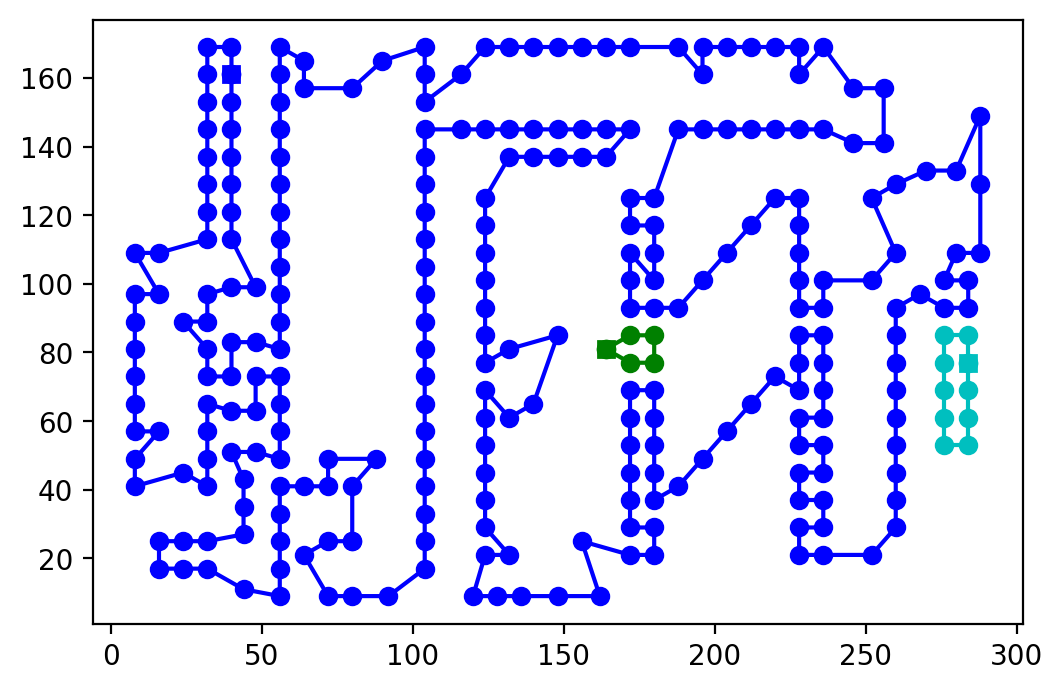

Adding cut for subtour: {'189', '049', '210', '214', '127', '026', '014', '061', '124', '208', '183', '120', '058', '070', '240', '178', '083', '052', '147', '194', '171', '229', '213', '102', '107', '062', '272', '243', '165', '031', '020', '108', '064', '154', '199', '265', '132', '254', '041', '018', '143', '032', '092', '037', '068', '195', '188', '279', '217', '093', '172', '075', '008', '028', '248', '130', '164', '196', '080', '118', '007', '224', '222', '244', '278', '269', '220', '114', '138', '270', '126', '035', '051', '215', '078', '161', '115', '072', '081', '109', '218', '193', '268', '059', '157', '209', '029', '016', '191', '186', '176', '160', '089', '067', '242', '122', '033', '250', '105', '094', '044', '042', '182', '011', '004', '128', '030', '252', '088', '146', '074', '015', '012', '267', '223', '071', '258', '047', '103', '099', '010', '251', '101', '221', '184', '203', '117', '019', '158', '077', '023', '230', '179', '264', '169', '276', '259', '150', '162', '2

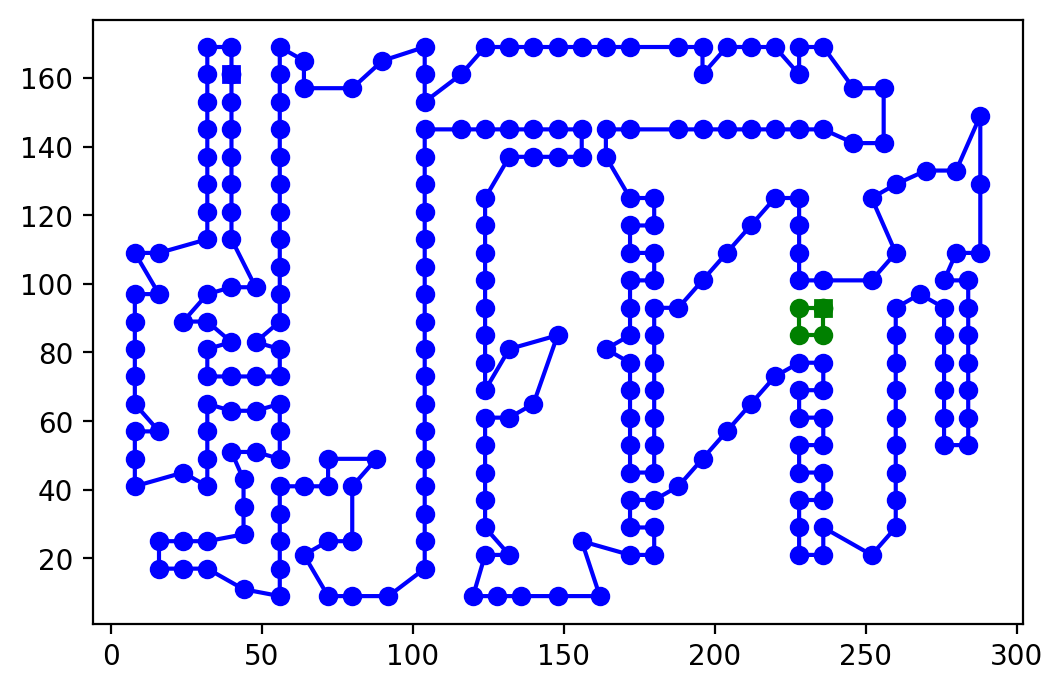

Adding cut for subtour: {'189', '049', '210', '214', '127', '026', '014', '061', '124', '208', '183', '120', '058', '070', '240', '178', '083', '052', '147', '194', '171', '229', '213', '102', '107', '062', '272', '243', '165', '031', '020', '108', '064', '154', '199', '265', '132', '041', '018', '140', '143', '032', '092', '037', '068', '141', '195', '188', '279', '217', '093', '172', '075', '008', '028', '248', '130', '164', '196', '080', '118', '007', '149', '224', '222', '244', '278', '269', '220', '114', '138', '270', '126', '035', '051', '237', '215', '078', '161', '239', '115', '072', '081', '109', '218', '193', '268', '059', '157', '209', '029', '016', '191', '186', '176', '160', '067', '235', '242', '122', '033', '250', '105', '094', '044', '042', '182', '011', '004', '128', '030', '089', '088', '146', '074', '015', '012', '267', '238', '246', '223', '071', '258', '047', '103', '099', '232', '010', '251', '101', '221', '184', '203', '117', '019', '158', '077', '023', '230', '1

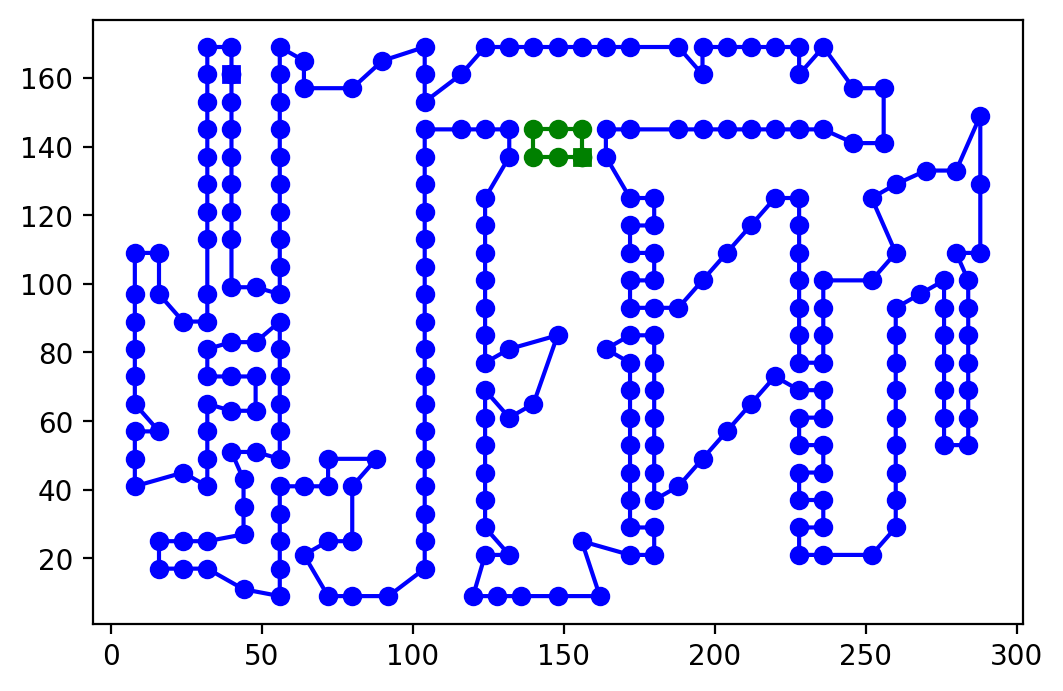

Adding cut for subtour: {'189', '049', '210', '214', '127', '026', '014', '061', '124', '208', '183', '120', '058', '070', '240', '178', '083', '052', '147', '194', '171', '229', '213', '102', '107', '062', '272', '243', '165', '031', '108', '064', '154', '199', '265', '254', '041', '018', '140', '143', '032', '092', '037', '068', '141', '195', '188', '279', '217', '093', '172', '075', '008', '028', '248', '164', '196', '080', '118', '007', '149', '224', '222', '244', '278', '269', '220', '114', '138', '270', '126', '035', '051', '237', '215', '078', '161', '239', '115', '072', '081', '109', '218', '193', '268', '059', '157', '209', '029', '016', '191', '186', '176', '160', '089', '235', '242', '122', '067', '033', '250', '105', '094', '044', '042', '182', '011', '004', '128', '030', '252', '088', '146', '074', '015', '012', '267', '238', '246', '223', '071', '258', '047', '103', '099', '232', '010', '251', '101', '221', '184', '203', '117', '158', '077', '023', '230', '179', '264', '1

In [13]:
t0 = time()
if not USE_CALLBACKS:
    amplSubTourElimination(ampl)
else:
    solverSubTourElimination(ampl, SOLVER, SOLVER_OPTIONS)

Get the solution, print it and display it

['049', '048', '047', '046', '045', '044', '059', '063', '062', '118', '061', '060', '043', '042', '041', '040', '039', '038', '037', '036', '035', '034', '033', '032', '031', '029', '028', '027', '026', '022', '025', '023', '024', '014', '015', '013', '012', '011', '010', '008', '009', '007', '006', '005', '004', '277', '276', '275', '274', '273', '272', '271', '016', '017', '018', '133', '134', '270', '269', '135', '136', '268', '267', '137', '138', '139', '149', '148', '147', '146', '145', '144', '143', '142', '141', '140', '266', '265', '264', '263', '262', '261', '260', '259', '258', '257', '254', '255', '256', '249', '248', '278', '279', '003', '280', '001', '002', '242', '243', '241', '240', '239', '238', '237', '236', '235', '234', '233', '232', '231', '246', '245', '244', '247', '250', '251', '230', '229', '228', '227', '226', '225', '224', '223', '222', '221', '220', '219', '218', '217', '216', '215', '214', '213', '212', '211', '210', '209', '252', '253', '208', '207', '206'

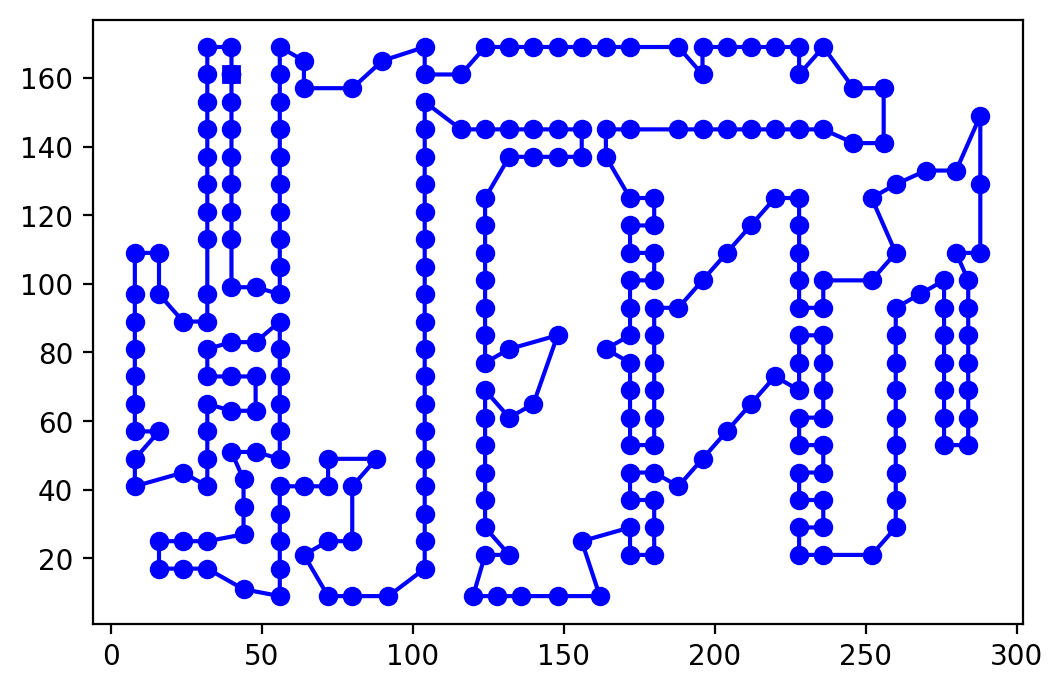

In [14]:
# Get the solution into ARCS
ARCS = ampl.getData("{(i,j) in PAIRS : X[i,j] > 0} X[i,j];")
ARCS = set([(i,j) for (i,j,k) in ARCS.toList()])

# Display it
tours = findSubTours(ARCS, NODES)
for st in tours:
    print(st)
plotTours(tours, CPOINTS)

In [15]:
ampl.getValue('Tour_Length')

2586.7696475631615

In [16]:
time()-t0 # seconds

9.330340385437012